In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [308]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\las_paper\ana_data\1200'
file_name =  "cry_2000p_origin.lmp"
file_path = os.path.join(root,file_name)

start_frame = 0
end_frame = 1999
step_frame = 2
###########

# 要分析的元素
ana_element = ['Si','O','Al']
# lmp对应的值
dic_charge = {2.4:'Si', -1.2:'O', 1.8:'Al', 0.6:'Li'}
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [310]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Atom:
    def __init__(self, id0=None, type0=None, q=None, x=None, y=None, z=None, 
                 vx=None, vy=None, vz=None, fx=None, fy=None, fz=None, 
                 c_ke_atom=None, c_pe_atom=None, v_e_total=None, frame=None, q4=None,q6=None,dis=None):
        self.id = int(id0)
        self.type = str(type0)
        self.x = x
        self.y = y
        self.z = z
        self.q = q
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = fx
        self.fy = fy
        self.fz = fz
        self.c_ke_atom = c_ke_atom
        self.c_pe_atom = c_pe_atom
        self.v_e_total = v_e_total
        self.q4 = q4
        self.q6 = q6
        self.dis = dis
        self.frame = frame
    def print_info(self):
        print(f'id:{int(self.id)}, type:{self.type}, x:{self.x}, y:{self.y}, z:{self.z}, q:{self.q}')
        print(f'vx:{self.vx}, vy:{self.vy}, vz:{self.vz}, fx:{self.fx}, fy:{self.fy}, fz:{self.fz}')
        print(f'E_total:{self.v_e_total}, E_kinetic:{self.c_ke_atom}, E_potential:{self.c_pe_atom}')
        print(f'q4:{self.q4} dis:{self.q6} q6:{self.dis} frame:{self.frame}')

In [312]:
def read_lmp(file_path):
    # 所有信息储存的总列表
    list_all_frames = []
    x_min,x_max,y_min,y_max,z_min,z_max = None,None,None, None,None,None
    box_size = [None, None, None]
    num_atom = None
    len_per_frame = None
    # 第一次打开,是看一下基本数据：
    with open(file_path,'r') as f_open:
        # 前三行都不要
        for i in range(3): 
            f_open.readline()
        # 第四行是Number
        num_atom = int(f_open.readline())
        # 定义一页的行数
        len_per_frame = num_atom + 9  
        # 第五行不要
        f_open.readline()
        # 存储range范围
        temp_range_list = []
        for i in range(3): 
            temp_min,temp_max = f_open.readline().split()
            temp_range_list.append(temp_min)
            temp_range_list.append(temp_max)
        # 将字符串转换为浮点数并直接赋值给变量
        x_min, x_max, y_min, y_max, z_min, z_max = [float(i) for i in temp_range_list]
    print(f'Num of atom: {num_atom}')
    print(f'X range: {x_min}  {x_max}')
    print(f'Y range: {y_min}  {y_max}')
    print(f'Z range: {z_min}  {z_max}\n')
    
    # 开始读取文件
    f_open = open(file_path,'r')
    # 记录当前行数
    count_row = 0
    for i_frame in range(start_frame, end_frame, step_frame):
        if i_frame%50==0:
            print(f'Now is reading frame {i_frame}')
        list_frame = []
        # 先判断下是不是我要的这页
        now_frame_count = len_per_frame*i_frame
        # 如果不是同一页，则跳过这一页,再继续空读
        while count_row!=now_frame_count:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            count_row+=len_per_frame
            for i in range(len_per_frame):
                f_open.readline()
        # 如果是同一页，那么就开始读取数据
        else:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            # 首先就是跳过表头的9行
            # for i in range(9):
            #     f_open.readline()
            # 读取表头九行的数据
            f_open.readline()
            time_step = int(f_open.readline())
            f_open.readline()
            atom_num = float(f_open.readline())
            f_open.readline()
            x_low,x_high = f_open.readline().split()
            y_low,y_high = f_open.readline().split()
            z_low,z_high = f_open.readline().split()
            f_open.readline()
            x_low,x_high,y_low,y_high,z_low,z_high = float(x_low),float(x_high),float(y_low),float(y_high),float(z_low),float(z_high)
            dic_system = {'timestep':time_step, 
                         'num_atoms':atom_num,
                          'x_low':x_low,'x_high':x_high,
                          'y_low':y_low,'y_high':y_high,
                          'z_low':z_low,'z_high':z_high,
                         }
            # 再读取其余的数据
            for j_row in range(num_atom):
                temp_data = f_open.readline().split()
                id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total = [float(i) for i in temp_data]
                #print(id0, type0, q, x, y, z)
                # 类型转换回 str
                type0 = dic_charge[q]
                temp_atom = Atom(id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total,i_frame)
                list_frame.append(temp_atom)
            # 这一页读取完了,首先是对原子的id排序
            list_frame = sorted(list_frame, key = lambda Atom:Atom.id)
            # 再存入信息帧中
            frame_data = {
                "atom_data":list_frame,
                'system_info':dic_system
            }
            list_all_frames.append(frame_data)
            count_row+=len_per_frame
         
    # 关闭文件
    print('文件读取完毕！')
    f_open.close()
    return list_all_frames
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)
    print('文件读取完毕！')
    return frames

In [314]:
file_type = file_path.split('\\')[-1].split('.')[-1]
frames = []
if file_type=='lmp':
    print('输入文件为lmp格式！')
    frames = read_lmp(file_path)   
elif file_type=='xyz':
    frames = read_xyz_frames(file_path)
    # 找出最大的x、y和z值
    max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
    max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
    max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])
    print("Maximum X value:", max_x)
    print("Maximum Y value:", max_y)
    print("Maximum Z value:", max_z)
else:
    print('输入文件有误！')

输入文件为lmp格式！
Num of atom: 6006
X range: 0.4926986886606599  125.73991493986794
Y range: 0.21480952639515394  54.820790473598514
Z range: 0.04468153368516692  11.403018466316183

Now is reading frame 0
Now is reading frame 50
Now is reading frame 100
Now is reading frame 150
Now is reading frame 200
Now is reading frame 250
Now is reading frame 300
Now is reading frame 350
Now is reading frame 400
Now is reading frame 450
Now is reading frame 500
Now is reading frame 550
Now is reading frame 600
Now is reading frame 650
Now is reading frame 700
Now is reading frame 750
Now is reading frame 800
Now is reading frame 850
Now is reading frame 900
Now is reading frame 950
Now is reading frame 1000
Now is reading frame 1050
Now is reading frame 1100
Now is reading frame 1150
Now is reading frame 1200
Now is reading frame 1250
Now is reading frame 1300
Now is reading frame 1350
Now is reading frame 1400
Now is reading frame 1450
Now is reading frame 1500
Now is reading frame 1550
Now is reading

# 分析读取1000帧数 那么时间间隔就是 0.08 ns  
# 选择 10ns时刻 那么就是 

In [317]:
start_frame_num = 4
end_frame_num = 44
# O Si Al Li
ana_element = ['Si','Al']

In [320]:
# 数据准备
start_frame = frames[start_frame_num]['atom_data']
end_frame = frames[end_frame_num]['atom_data']
end_info = frames[start_frame_num]['system_info']
lx = end_info['x_high']
ly = end_info['y_high']
lz = end_info['z_high']
box_size = np.array([lx,ly,lz])
start_xyz = [[i.x,i.y,i.z] for i in start_frame if i.type in ana_element]
end_xyz = [[i.x,i.y,i.z] for i in end_frame if i.type in ana_element]
print(box_size)
print(len(end_xyz))

[125.66240075  54.7869954   11.39598891]
1716


In [346]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
list1 = np.array(start_xyz)
list2 = np.array(end_xyz)

# 盒子大小
boxsize = np.array(box_size)  # Lx, Ly, Lz
#######
v_max = 0.5
v_min = 0

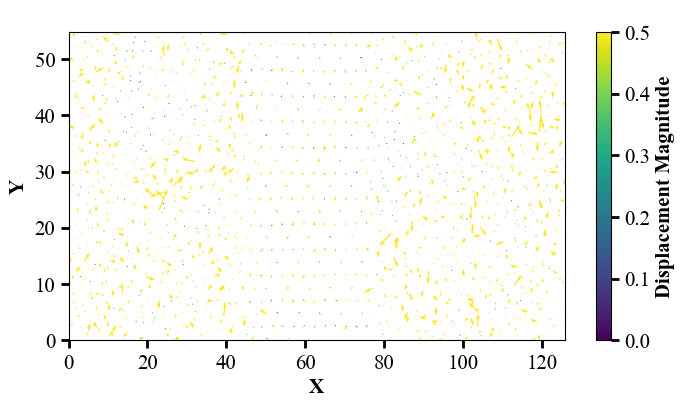

In [348]:
displacement = list2 - list1
displacement -= boxsize * np.round(displacement / boxsize)
magnitude = np.linalg.norm(displacement, axis=1)

# 原点和位移向量（xy）
x, y = list1[:, 0], list1[:, 1]
u, v = displacement[:, 0], displacement[:, 1]

# 设置颜色归一化（设定 colorbar 范围）
vmax = v_max  # 你想设定的最大颜色对应的值
norm = colors.Normalize(vmin=v_min, vmax=vmax)

# 创建图像
fig, ax = plt.subplots(figsize=(8, 4))

# 注意这里加入 norm=norm
q = ax.quiver(x, y, u, v, magnitude, cmap='viridis', norm=norm,
              angles='xy', scale_units='xy', scale=1)

# 限制绘图范围
ax.set_xlim(0, boxsize[0])
ax.set_ylim(0, boxsize[1])
ax.set_aspect('auto')

# 坐标轴标签
ax.set_xlabel("X", fontsize=15, fontweight='bold')
ax.set_ylabel("Y", fontsize=15, fontweight='bold')
ax.set_title(" ", fontsize=15, fontweight='bold')

# 坐标轴刻度标签 & 线条加粗
ax.tick_params(axis='both', labelsize=15, width=2, length=6)


# colorbar 设置
cbar = fig.colorbar(q, ax=ax)
cbar.set_label('Displacement Magnitude', fontsize=15, fontweight='bold')
cbar.ax.tick_params(labelsize=15, width=2, length=6)

# 开始画图

In [ ]:
start_frame_num = 0
end_frame_num = 50

ana_element = 'Si'

color_bar = [0,1.4]
####################
start_xyz,end_xyz = get_xyz(frames,start_frame_num,end_frame_num,ana_element)

自动轴


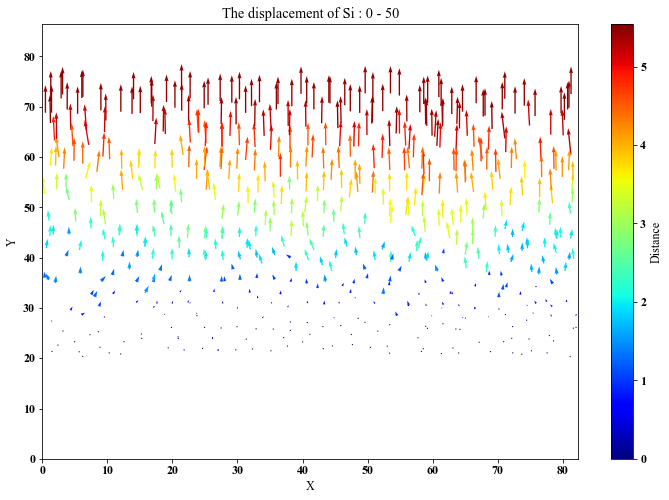

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 positions 是一个包含两个帧的原子位置的三维数组，每行代表一个原子的x、y、z坐标
frame1 = start_xyz
frame2 = end_xyz


# 计算三维原子位移矢量，考虑周期性边界条件
displacements = frame2 - frame1

# 计算位移矢量的投影到xy平面上，考虑周期性边界条件

# box_size = [x_size, y_size, z_size]  # 假设 box_size 包含x、y、z方向的单元格尺寸
x_size = box_size[0]
y_size=box_size[1]
z_size= box_size[2]


displacements[:, 0] = (displacements[:, 0] + 0.5 * box_size[0]) % box_size[0] - 0.5 * box_size[0]
displacements[:, 1] = (displacements[:, 1] + 0.5 * box_size[1]) % box_size[1] - 0.5 * box_size[1]

# 计算每个原子的距离，只考虑xy平面上的距离
distances = np.linalg.norm(displacements[:, :2], axis=1)

# 设置颜色映射，距离长的原子位移颜色越深
cmap = plt.get_cmap('jet')
normalize = plt.Normalize(vmin=min(distances), vmax=max(distances))
colors = cmap(normalize(distances))

# 创建一个图形
plt.figure(figsize=(12, 8))
plt.quiver(frame1[:, 0], frame1[:, 1], displacements[:, 0], displacements[:, 1], color=colors, angles='xy', scale_units='xy', scale=1)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Distance')

# 设置坐标轴范围等其他属性
plt.xlim(0, x_size)
plt.ylim(0, y_size)
plt.xlabel('X')
plt.ylabel('Y')
title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num) ## + ' frame (100ns/1000frames)'
plt.title(title)
print('自动轴')
# 显示图形
plt.show()


定制坐标轴


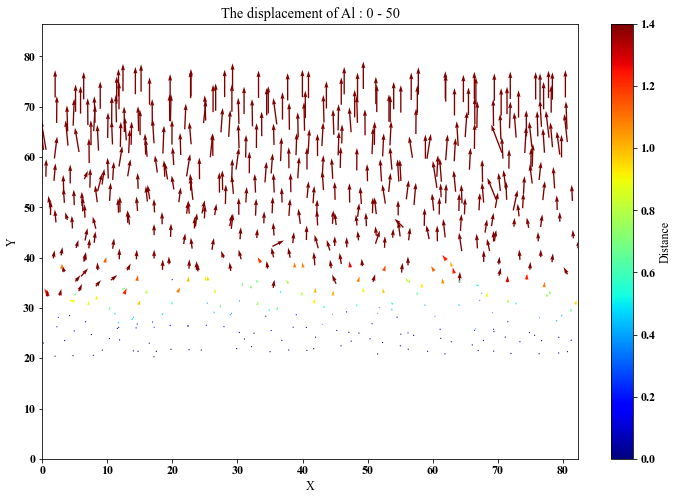

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 positions 是一个包含两个帧的原子位置的三维数组，每行代表一个原子的x、y、z坐标
frame1 = start_xyz
frame2 = end_xyz


# 计算三维原子位移矢量，考虑周期性边界条件
displacements = frame2 - frame1

# 计算位移矢量的投影到xy平面上，考虑周期性边界条件

# box_size = [x_size, y_size, z_size]  # 假设 box_size 包含x、y、z方向的单元格尺寸
x_size = box_size[0]
y_size=box_size[1]
z_size= box_size[2]


displacements[:, 0] = (displacements[:, 0] + 0.5 * box_size[0]) % box_size[0] - 0.5 * box_size[0]
displacements[:, 1] = (displacements[:, 1] + 0.5 * box_size[1]) % box_size[1] - 0.5 * box_size[1]

# 计算每个原子的距离，只考虑xy平面上的距离
distances = np.linalg.norm(displacements[:, :2], axis=1)

# 设置颜色映射，距离长的原子位移颜色越深
cmap = plt.get_cmap('jet')

normalize = plt.Normalize(vmin= color_bar[0], vmax=color_bar[1])
colors = cmap(normalize(distances))

# 创建一个图形
plt.figure(figsize=(12, 8))
plt.quiver(frame1[:, 0], frame1[:, 1], displacements[:, 0], displacements[:, 1], color=colors, angles='xy', scale_units='xy', scale=1)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Distance')

# 设置坐标轴范围等其他属性
plt.xlim(0, x_size)
plt.ylim(0, y_size)
plt.xlabel('X')
plt.ylabel('Y')
title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num) ## + ' frame (100ns/1000frames)'
plt.title(title)
print('定制坐标轴')
# 显示图形
plt.show()


# 其他方式

C:\Users\zhang\AppData\Local\Temp\ipykernel_11548\3624650125.py:33: RuntimeWarning: invalid value encountered in divide
  displacement_direction = displacements / displacement_magnitude[:, np.newaxis]


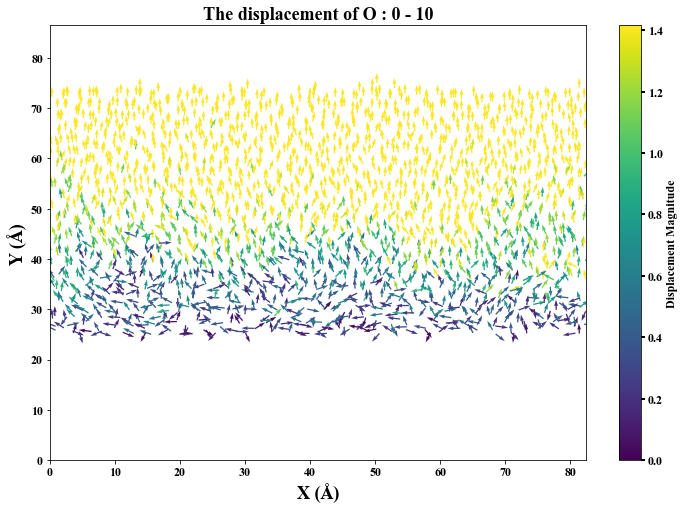

In [44]:
# 分析两个帧数之间的msd  也就是位移差
start_frame_num = 0
end_frame_num = 10

ana_element = 'O'
####################
start_xyz,end_xyz = get_xyz(frames,start_frame_num,end_frame_num,ana_element)
draw(start_frame_num,end_frame_num ,start_xyz,end_xyz,ana_element)


In [18]:
# 

In [14]:
start_frame_num = 190
end_frame_num = 320

ana_element = 'O'
####################
start_xyz,end_xyz = get_xyz(frames,start_frame_num,end_frame_num,ana_element)

IndexError: list index out of range

In [ ]:
# 取出相对应的帧数 
start_frame = frames[start_frame_num]
end_frame = frames[end_frame_num]

start_xyz, end_xyz = [],[]
for i,j in zip(start_frame['atoms'], end_frame['atoms']):
    if i['element'] == ana_element:
        start_xyz.append([i['x'],i['y'],i['z']])
    if j['element'] == ana_element:
        end_xyz.append([j['x'],j['y'],j['z']])
start_xyz, end_xyz = np.array(start_xyz), np.array(end_xyz)
print(len(start_xyz),len(end_xyz))

In [ ]:
x_list,y_list,msd = [], [],[]
for i,j in zip(start_xyz,end_xyz):
        x_list.append(j[0])
        y_list.append(j[1])
        dis = cal_dis(i,j,box_size)
        msd.append(dis)
print(len(msd))

In [ ]:
import matplotlib.pyplot as plt


# 假设x_list包含原子的x坐标，z_list包含原子的z坐标，cn_list包含权重值
# x_list = [1.0, 2.0, 3.0, 4.0]  # 用您的实际数据替换这些示例数据
# z_list = [0.5, 1.0, 1.5, 2.0]  # 用您的实际数据替换这些示例数据
# cn_list = [0.1, 0.5, 0.8, 0.3]  # 用您的实际数据替换这些示例数据

# 创建画布
plt.figure(figsize=(10, 6))

# 绘制二维权重值分布图
plt.scatter(x_list, y_list, c=msd, cmap='cool', s=10)

# 添加颜色栏
cbar = plt.colorbar()
cbar.set_label('Weight Values')
title = ana_element+': '+ str(start_frame_num)+' to '+ str(end_frame_num)+ ' MSD'
# 添加标题和坐标轴标签
plt.title(title)
plt.xlabel('X')
plt.ylabel('Y')

# 显示图形
plt.show()


In [ ]:
# 设置全局字体属性
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12


# 两帧原子的xyz数据，每一帧包含原子的位置信息
frame1 = np.array(start_xyz)
frame2 = np.array(end_xyz)

# 盒子尺寸，假设为 [box_x, box_y, box_z]
# box_size = [10.0, 10.0, 10.0]

# 计算位移向量
displacements = frame2[:, :2] - frame1[:, :2]

# 考虑周期性边界条件，根据盒子尺寸修正位移
for i in range(len(displacements)):
    for dim in range(2):  # 仅考虑 xy 平面
        if displacements[i, dim] > box_size[dim] / 2:
            displacements[i, dim] -= box_size[dim]
        elif displacements[i, dim] < -box_size[dim] / 2:
            displacements[i, dim] += box_size[dim]

# 计算位移大小和方向
displacement_magnitude = np.linalg.norm(displacements, axis=1)
displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

plt.figure(figsize=(15, 10))  # 设置图像宽度为8英寸，高度为6
# 绘制位移图
plt.quiver(frame1[:, 0], frame1[:, 1], displacement_direction[:, 0], displacement_direction[:, 1], 
           displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1)

# 设置图形范围，根据盒子尺寸
plt.xlim(0, box_size[0])
plt.ylim(0, box_size[1])

plt.title('The displacement of O between the 1ns frame and the 12 frame')
# 添加颜色条
plt.colorbar(label='Displacement Magnitude')

# 显示图形
plt.show()


# 最后的结果

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties
# 设置全局字体属性
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# 设置图像大小
fig = plt.figure(figsize=(12, 8))

# 两帧原子的xyz数据，每一帧包含原子的位置信息
frame1 = np.array(start_xyz)
frame2 = np.array(end_xyz)

# 盒子尺寸，假设为 [box_x, box_y, box_z]
#box_size = [10.0, 10.0, 10.0]

# 计算位移向量
displacements = frame2[:, :2] - frame1[:, :2]

# 考虑周期性边界条件，根据盒子尺寸修正位移
for i in range(len(displacements)):
    for dim in range(2):  # 仅考虑 xy 平面
        if displacements[i, dim] > box_size[dim] / 2:
            displacements[i, dim] -= box_size[dim]
        elif displacements[i, dim] < -box_size[dim] / 2:
            displacements[i, dim] += box_size[dim]

# 计算位移大小
displacement_magnitude = np.linalg.norm(displacements, axis=1)

# 计算位移方向
displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

# 设置箭头的长度的倍数
arrow_scale = 1.5  # 可以根据需要调整箭头的长度

# 设置颜色映射范围，根据位移大小来映射颜色
norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

# 绘制位移图，将位移大小与箭头长度相乘
plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
           arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

# 
# 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


# 设置图形范围，根据盒子尺寸
plt.xlim(0, box_size[0])
plt.ylim(0, box_size[1])
plt.xlabel('X (Å)',fontproperties=label_font)
plt.ylabel('Y (Å)',fontproperties=label_font)
# 添加颜色条

title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)+' frame'
plt.title(title, fontproperties=label_font)


# 设置颜色条字体大小、粗细和字体族
cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

cbar = plt.colorbar(label='Displacement Magnitude')

# 显示图形
plt.show()


In [ ]:
title